In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

batch_size = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Assignment 1 : Deep Learning by Samuel DIAI


## A - Computer Vision
### Question 1



In [ ]:
class Encoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
          super(Encoder, self).__init__()
          # encoder part
          self.encoder_net = nn.Sequential(nn.Linear(x_dim, h_dim1),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(h_dim1, h_dim2),
                                           nn.ReLU(inplace = True)
                                           )
          self.mean = nn.Linear(h_dim2, z_dim)
          self.std = nn.Linear(h_dim2, z_dim)

    def forward(self, x):
        x = self.encoder_net(x)
        mean = self.mean(x)
        std = self.std(x)
        return mean, F.softplus(std)


class Decoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
          super(Decoder, self).__init__()
          # decoder part
          self.decoder_net = nn.Sequential(nn.Linear(z_dim, h_dim2),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(h_dim2, h_dim1),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(h_dim1, x_dim))
    def forward(self, x):
        x = self.decoder_net(x)
        # Ensure the output of the decoder is between 0 and 1 as it is the Bernouilli parameter.
        return torch.sigmoid(x)

    

class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        # decoder part
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim)

    
    def sampling(self, mu, std):
        eps = torch.randn_like(std)
        return eps * torch.sqrt(std) + mu # return z sample
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

# compute loss
def get_loss(bernoullis, x, mu, std, x_dim):
    loss_recon = nn.BCELoss(reduction = 'sum')
    loss_reg = 0.5 * torch.sum(std + mu.pow(2) - 1 - torch.log(std))
    print(x.shape)
    return loss_recon(bernoullis, x.view(-1, x_dim)) + loss_reg
    

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=20)
optimizer = optim.Adam(vae.parameters())
if torch.cuda.is_available():
    vae.cuda()

In [ ]:

class Encoder_CNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
          super(Encoder_CNN, self).__init__()
          # encoder part
          self.encoder_net = nn.Sequential(nn.Conv2d(1, 16, 3),
                                           nn.MaxPool2d(2),
                                           nn.ReLU(),
                                           nn.Conv2d(16, 32, 3),
                                           nn.MaxPool2d(2),
                                           nn.ReLU(),
                                           nn.Conv2d(32, 64, 3),
                                           nn.Flatten()
                                           )
          self.mean = nn.Linear(h_dim, z_dim)
          self.std = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        for layer in self.encoder_net:
            x = layer(x)
        mean = self.mean(x)
        std = self.std(x)
        return mean, F.softplus(std)


class Decoder_CNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
          super(Decoder_CNN, self).__init__()
          self.x_dim = x_dim; self.h_dim = h_dim; self.z_dim = z_dim
          # decoder part
          self.decoder_net = nn.Sequential(nn.ConvTranspose2d(20, 16, 3, stride=2),  # b, 16, 5, 5
                                           nn.ReLU(),
                                           nn.ConvTranspose2d(16, 8, 3, stride=3, padding=1),  # b, 8, 15, 15
                                           nn.ReLU(),
                                           nn.ConvTranspose2d(8, 4, 3, stride=2, padding=0),
                                           nn.ReLU(),
                                           nn.ConvTranspose2d(4, 1, 2, stride=2, padding=1))
    def forward(self, x):
        x = x.view(batch_size, self.z_dim, 1, 1)
        for layer in self.decoder_net:
            x = layer(x)
        # Ensure the output of the decoder is between 0 and 1 as it is the Bernouilli parameter.
        return torch.sigmoid(x)

    

class VAE_CNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE_CNN, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.encoder = Encoder_CNN(x_dim, h_dim, z_dim)
        # decoder part
        self.decoder = Decoder_CNN(x_dim, h_dim, z_dim)

    
    def sampling(self, mu, std):
        eps = torch.randn_like(std)
        return eps * torch.sqrt(std) + mu # return z sample
    
    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

# compute loss
def get_loss(bernoullis, x, mu, std, x_dim):
    loss_recon = nn.BCELoss(reduction = 'sum')
    loss_reg = 0.5 * torch.sum(std + mu.pow(2) - 1 - torch.log(std))

    return loss_recon(bernoullis.view(-1, x_dim), x.view(-1, x_dim)) + loss_reg

# build model
vae_cnn = VAE_CNN(x_dim=784, h_dim= 576,  z_dim=20)
optimizer_cnn = optim.Adam(vae_cnn.parameters(), lr = 0.001, weight_decay=0.01)
if torch.cuda.is_available():
    vae_cnn.cuda()

In [ ]:

def train(epoch, optimizer, vae):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        optimizer.zero_grad()
        
        bernoullis, mu, std = vae(data)
        loss = get_loss(bernoullis, data, mu, std, vae.x_dim)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return train_loss/len(train_loader.dataset)

def test(vae):
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
                data = data.cuda()
            bernoullis, mu, std = vae(data)
            
            # sum up batch loss
            test_loss += get_loss(bernoullis, data, mu, std, vae.x_dim).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [ ]:
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
# Visualize the output y
def vis_features(list_images, ax, nrow = 8):

    # Create a grid of images
    out = make_grid(list_images, nrow)
    # Convert to numpy image
    out = np.transpose(out.cpu().detach().numpy())
    # Show
    ax.imshow(out)
    return ax

In [ ]:
test_losses = []
train_losses = []
n_images = 64
dict_epoch_images = {}
first_batch = next(iter(test_loader))[0].cuda()
for epoch in range(1, 101):
    if epoch == 1 or epoch == 10 or epoch == 80:
      bernoullis, mu, std = vae_cnn(first_batch)
      first_images = bernoullis[:n_images, :].reshape([64,1,28,28]).permute(0,1,3,2)
      dict_epoch_images[epoch] = first_images
    vae_cnn.train()
    train_loss = train(epoch, optimizer_cnn, vae_cnn) 
    train_losses.append(train_loss)
    vae_cnn.eval()
    test_loss = test(vae_cnn)
    test_losses.append(test_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 496.933672
Train Epoch: 1 [10000/60000 (17%)]	Loss: 261.095762
Train Epoch: 1 [20000/60000 (33%)]	Loss: 222.732344
Train Epoch: 1 [30000/60000 (50%)]	Loss: 207.865918
Train Epoch: 1 [40000/60000 (67%)]	Loss: 200.299707
Train Epoch: 1 [50000/60000 (83%)]	Loss: 180.435117
====> Epoch: 1 Average loss: 237.6800
====> Test set loss: 167.5106
Train Epoch: 2 [0/60000 (0%)]	Loss: 169.256563
Train Epoch: 2 [10000/60000 (17%)]	Loss: 161.245771
Train Epoch: 2 [20000/60000 (33%)]	Loss: 151.502168
Train Epoch: 2 [30000/60000 (50%)]	Loss: 150.152627
Train Epoch: 2 [40000/60000 (67%)]	Loss: 144.815273
Train Epoch: 2 [50000/60000 (83%)]	Loss: 146.681084
====> Epoch: 2 Average loss: 152.3684
====> Test set loss: 141.9906
Train Epoch: 3 [0/60000 (0%)]	Loss: 143.652080
Train Epoch: 3 [10000/60000 (17%)]	Loss: 145.846846
Train Epoch: 3 [20000/60000 (33%)]	Loss: 143.364922
Train Epoch: 3 [30000/60000 (50%)]	Loss: 139.026406
Train Epoch: 3 [40000/60000 (67%)]	Loss: 136.50

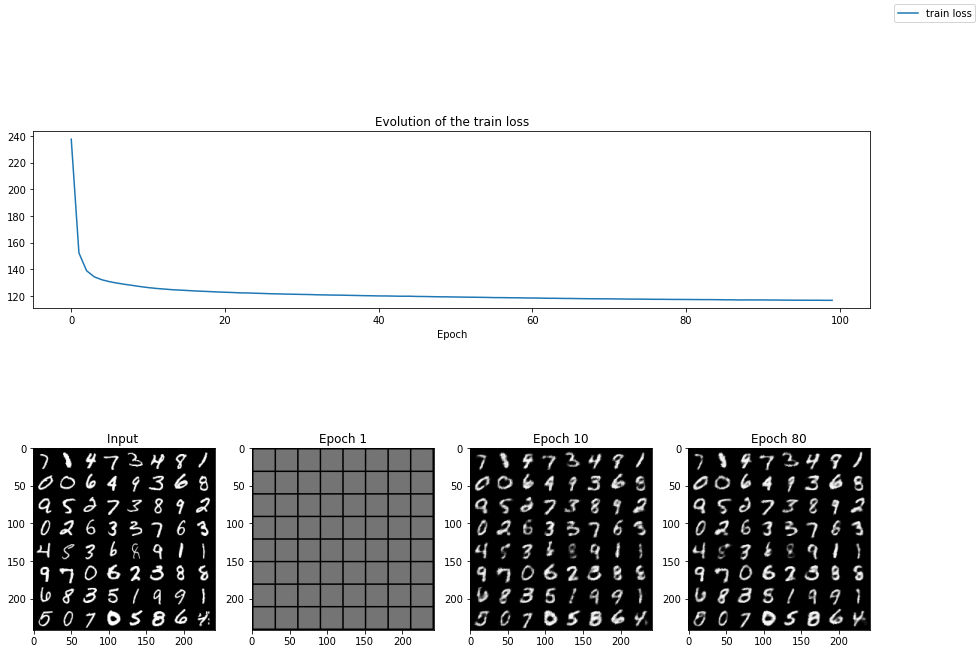

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15, 15))
axs[0].set_title("Input ")
vis_features(first_batch[:64].permute(0, 1, 3, 2), axs[0])
count = 1
for key, value in dict_epoch_images.items():
    axs[count].set_title("Epoch %s" % key)
    vis_features(value, axs[count])
    count += 1

axbig = fig.add_subplot(411)
axbig.plot(train_losses, label = 'train loss')
axbig.set_title('Evolution of the train loss')
axbig.set_xlabel('Epoch')
fig.legend()
fig.show()

In [ ]:
test_losses = []
train_losses = []
n_images = 64
dict_epoch_images = {}
first_batch = next(iter(test_loader))[0].cuda()
for epoch in range(1, 101):
    if epoch == 1 or epoch == 10 or epoch == 80:
      bernoullis, mu, std = vae(first_batch)
      first_images = bernoullis[:n_images, :].reshape([64,1,28,28]).permute(0,1,3,2)
      dict_epoch_images[epoch] = first_images
    vae.train()
    train_loss = train(epoch, optimizer, vae) 
    train_losses.append(train_loss)
    vae.eval()
    test_loss = test(vae)
    test_losses.append(test_loss)

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.481172
Train Epoch: 1 [10000/60000 (17%)]	Loss: 191.030977
Train Epoch: 1 [20000/60000 (33%)]	Loss: 179.181055
Train Epoch: 1 [30000/60000 (50%)]	Loss: 151.452275
Train Epoch: 1 [40000/60000 (67%)]	Loss: 147.593857
Train Epoch: 1 [50000/60000 (83%)]	Loss: 141.156328
====> Epoch: 1 Average loss: 166.7701
====> Test set loss: 130.1151
Train Epoch: 2 [0/60000 (0%)]	Loss: 131.361162
Train Epoch: 2 [10000/60000 (17%)]	Loss: 127.438770
Train Epoch: 2 [20000/60000 (33%)]	Loss: 125.490322
Train Epoch: 2 [30000/60000 (50%)]	Loss: 122.507236
Train Epoch: 2 [40000/60000 (67%)]	Loss: 116.699316
Train Epoch: 2 [50000/60000 (83%)]	Loss: 119.049863
====> Epoch: 2 Average loss: 123.2298
====> Test set loss: 116.1801
Train Epoch: 3 [0/60000 (0%)]	Loss: 118.992910
Train Epoch: 3 [10000/60000 (17%)]	Loss: 110.470205
Train Epoch: 3 [20000/60000 (33%)]	Loss: 119.667139
Train Epoch: 3 [30000/60000 (50%)]	Loss: 118.339043
Train Epoch: 3 [40000/60000 (67%)]	Loss: 113.45

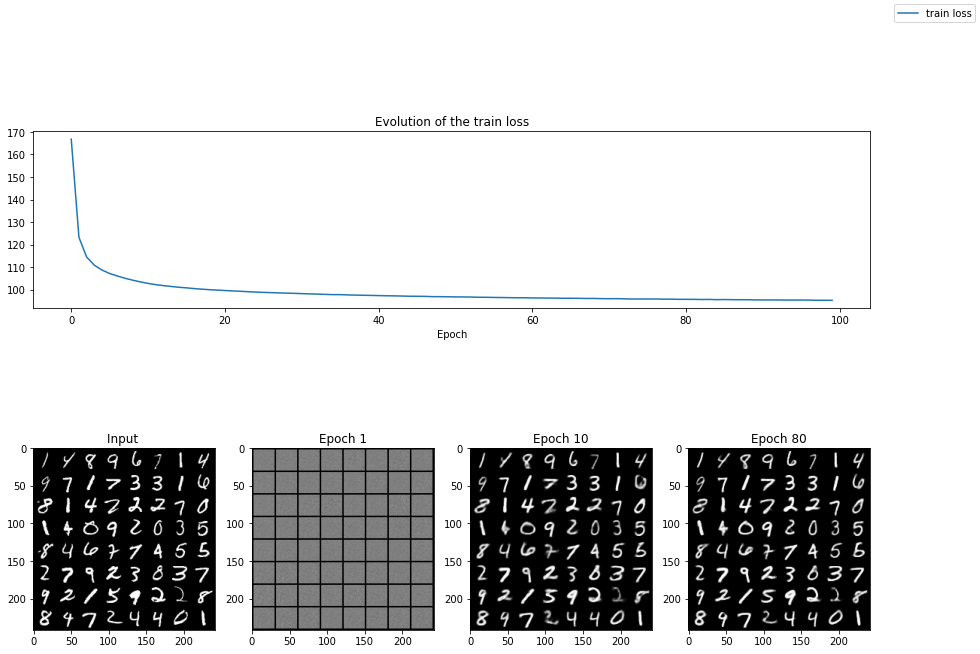

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15, 15))
axs[0].set_title("Input ")
vis_features(first_batch[:64].permute(0, 1, 3, 2), axs[0])
count = 1
for key, value in dict_epoch_images.items():
    axs[count].set_title("Epoch %s" % key)
    vis_features(value, axs[count])
    count += 1

axbig = fig.add_subplot(411)
axbig.plot(train_losses, label = 'train loss')
axbig.set_title('Evolution of the train loss')
axbig.set_xlabel('Epoch')
fig.legend()
fig.show()